In [1]:
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

from pathlib import Path
import pickle

# Check package versions
import gammapy
import numpy as np
import astropy
import regions
from scipy.optimize import curve_fit

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)

import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import PointSkyRegion
from gammapy.data import DataStore
from gammapy.maps import MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset
)
from gammapy.modeling.models import (
    create_crab_spectral_model,
    SkyModel,
    LogParabolaSpectralModel,
    ConstantTemporalModel
)
from gammapy.makers import (
    SpectrumDatasetMaker,
    WobbleRegionsFinder,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker
)
from gammapy.utils.scripts import make_path

from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator, FluxPoints

from astropy.time import Time
from astropy.table import Table
from astropy.io import fits

from gammapy.modeling.models import Models

from gammapy.maps import TimeMapAxis
TimeMapAxis.time_format = "mjd"

# import seaborn as sns
import matplotlib.style as style

from astropy.table import Table
from scipy.stats import chi2
import numpy as np

gammapy: 0.20.1
numpy: 1.24.4
astropy 5.2.2
regions 0.7


In [2]:
# sns.set_theme()
# sns.set_style("ticks")
# sns.set_color_codes("colorblind")
# sns.set_palette("colorblind")

In [3]:
def mjd_to_iso(times):
    return Time(times, format="mjd", scale='utc').iso


def set_twin_time_axis(ax):
    ax2 = ax.twiny()

    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator(interval=2)  # every month

    # format the ticks
    ax2.xaxis.set_major_locator(years)
    ax2.xaxis.set_minor_locator(months)

    #Manually adjust
    datemin = np.datetime64(mjd_to_iso(59150), 'W')
    datemax = np.datetime64(mjd_to_iso(59670), 'W')

    ax2.set_xlim(datemin, datemax)

    ax2.format_xdata = mdates.DateFormatter('%b')

    mjdlims = Time([datemin, datemax]).mjd
    ax.set_xlim(mjdlims[0], mjdlims[1])
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

    ax2.tick_params(axis='x', which='major', pad=13)
    ax2.tick_params(axis='x', which='minor', pad=10)

    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax2.get_xticklabels(which='both'), fontsize=20)
    plt.setp(ax.get_yticklabels(which='both'), fontsize=20)
    

def fit_constant(x, a):
    return a * np.ones_like(x)


def weighted_average(table, sys_error=0):
    val = table["flux"]
    uncertainty = np.sqrt((sys_error * table["flux"])**2 + table["flux_err"]**2)
    return (val/uncertainty**2).sum() / (1/uncertainty**2).sum(), np.sqrt(1/np.sum(1/uncertainty**2))


def calculate_chi2_pvalue(table, sys_error=0):
    uncertainty = np.sqrt((sys_error * table["flux"])**2 + table["flux_err"]**2)
    flux = table["flux"]
    mean_flux = (flux/uncertainty**2).sum() / (1/uncertainty**2).sum()
    mean_flux_err = np.sqrt(1/np.sum(1/uncertainty**2))
    print(f"Weighted mean flux: {mean_flux:.3e} +/- {mean_flux_err:.3e} cm-2 s-1")
    
    chi2_value = np.sum((table["flux"] - mean_flux)**2/uncertainty**2)
    ndf = len(table["flux"]) - 1
    pvalue = chi2.sf(x=chi2_value, df=ndf)
    print(f"Chi2: {chi2_value:.1f}, ndf: {ndf}, P-value: {pvalue:.2e}")
    return chi2_value, ndf, pvalue


def plot_total_error_bars(sys_uncertainty: float, lightcurve):
    time_min = np.hstack(lightcurve["time_min"])
    time_max = np.hstack(lightcurve["time_max"])
    time_mjd = 0.5 * (time_min + time_max)
    flux = np.hstack(lightcurve["flux"])
    statistical_err = np.hstack(lightcurve["flux_err"])

    sys_err = sys_uncertainty * flux  # sys_uncertainty is the percentage of flux values
    total_error = np.sqrt(statistical_err**2 + sys_err**2)  # added in quadrature
    ax.errorbar(time_mjd, flux_lst1, yerr=total_error, fmt=".", color="gray", alpha=0.5)
    

def plot_crab_average_flux_band():
    plt.axhline(
    mean_flux, c='b', ls='-.',
    label='Best fit value to a constant flux (LST-1)',
    )

    plt.axhspan(
        mean_flux - mean_flux_err, 
        mean_flux + mean_flux_err, 
        alpha=0.2, color='b'
    )    

In [4]:
data_dir = Path("/fefs/aswg/workspace/daniel.morcuende/data")

dl3_dir_path = data_dir / "real/DL3/Crab_performance/AllSkyMC_v0.9.9/intensity80/all_nodes/gh_eff_0.7_th_cont_0.7"
# dl3_dir_path = "/fefs/aswg/workspace/juan.jimenez/data/lst1_systematics/_dl3"

total_datastore = DataStore.from_dir(dl3_dir_path)

observations = total_datastore.get_observations(
    required_irf=["aeff", "edisp", "rad_max"]
)

In [5]:
obs_table = total_datastore.obs_table

In [6]:
obs_ids = np.array(obs_table["OBS_ID"])

In [7]:
print(f'Total livetime of observations {obs_table["LIVETIME"].data.sum()/3600:.2f} hrs')

Total livetime of observations 34.20 hrs


In [8]:
e_reco_min = 0.1
e_reco_max = 30

e_true_min = 0.005
e_true_max = 200

# Using bins per decade
e_reco_bin_p_dec = 5
e_true_bin_p_dec = 10

energy_axis = MapAxis.from_energy_bounds(
    e_reco_min, e_reco_max, 
    nbin=e_reco_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    e_true_min, e_true_max, 
    nbin=e_true_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy_true"
)

# Select minimum and maximum energy edges for LC and SED, from the energy_axis to be used un the Dataset
# Here we use a different minimum energy than energy_axis, but the same energy bins.
# For analyzers who do not want energy bins per decade, or some custom bins for energy_axis, 
# make appropriate changes in each axis.
e_fit_min = energy_axis.edges[1].value
e_fit_max = energy_axis.edges[-1].value
e_fit_bin_p_dec = e_reco_bin_p_dec

# Just to have a separate MapAxis for spectral fit energy range
energy_fit_edges = MapAxis.from_energy_bounds(
    e_fit_min, e_fit_max, 
    nbin=e_fit_bin_p_dec, per_decade=True, 
    unit="TeV"
).edges

e_lc_min = energy_axis.edges[0]
e_lc_max = energy_axis.edges[-1]

print("Spectral fit will be done in energy edges:\n", energy_fit_edges)
print(f"LC will be estimated from {e_lc_min:.1f} to {e_lc_max:.1f}")

Spectral fit will be done in energy edges:
 [ 0.15507714  0.2404892   0.37294378  0.57835055  0.89688951  1.39087062
  2.15692241  3.34489362  5.18716544  8.04410792 12.47457266 19.34521077
 30.        ] TeV
LC will be estimated from 0.1 TeV to 30.0 TeV


In [9]:
# Calculate & plot Crab reference flux
# https://doi.org/10.1016/j.jheap.2015.01.002
crab = create_crab_spectral_model("magic_lp")

crab.amplitude.error = 0.03e-11 * u.Unit("cm-2 s-1 TeV-1")
crab.alpha.error = 0.01
crab.beta.error = 0.01/np.log(10)


flux_crab = crab.integral(e_lc_min, e_lc_max)
flux_crab_error = flux_crab * 0
# flux_crab, flux_crab_error = crab.integral_error(e_lc_min, e_lc_max)

# print(f"Flux [{e_lc_min:.1f}, {e_lc_max:.1f}]: {flux_crab:.2e} +- {flux_crab_error:.2e}")

In [10]:
# Get the GTI parameters of each observations to create time intervals for plotting LC
t_start  = []
t_stop   = []
tot_time = []

for obs in observations:
    gti = obs.gti
    
    t_start.append( gti.time_start[0])
    t_stop.append(  gti.time_stop[0])
    tot_time.append(gti.time_sum.value)

t_start  = np.sort(np.array(t_start))
t_stop   = np.sort(np.array(t_stop))
tot_time = np.array(tot_time)

t_start = Time(t_start)
t_stop  = Time(t_stop)

t_day = np.unique(np.rint(t_start.mjd))

# To make the range night-wise, keep the MJD range in half integral values
t_range = [Time([t-0.5, t+0.5], format="mjd", scale="utc") for t in t_day]

In [11]:
target_position = SkyCoord.from_name("Crab Nebula", frame='icrs')
on_region = PointSkyRegion(target_position)

# geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"]
)

In [12]:
# tell the background maker to use the WobbleRegionsFinder, let us use 1 off
region_finder = WobbleRegionsFinder(n_off_regions=1)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

In [13]:
%%time
# The final object will be stored as a Datasets object

# There will be an error message on use_region_center=False. It is a bug message in gammapy, so just ignore it
datasets = Datasets()

for observation in observations:
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(observation.obs_id)),
        observation
    )
    dataset_on_off = bkg_maker.run(
        dataset=dataset, 
        observation=observation
    )
    datasets.append(dataset_on_off) 

CPU times: user 2min 27s, sys: 33.2 s, total: 3min
Wall time: 3min 33s


In [14]:
stacked_dataset = Datasets(datasets).stack_reduce()

In [15]:
print(stacked_dataset)

SpectrumDatasetOnOff
--------------------

  Name                            : lqB-EnJW 

  Total counts                    : 309844 
  Total background counts         : 240122.00
  Total excess counts             : 69722.00

  Predicted counts                : 274983.00
  Predicted background counts     : 274983.00
  Predicted excess counts         : nan

  Exposure min                    : 8.17e+05 m2 s
  Exposure max                    : 2.58e+10 m2 s

  Number of total bins            : 13 
  Number of fit bins              : 13 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 28753.62

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 240122 
  Acceptance                      : 13 
  Acceptance off                  : 13 



In [18]:
model_file = dl3_dir_path / "analysis_50GeV_30TeV/model_stacked_8bin_r2914_to_r7277_gh_eff_0.7_th_cont_0.7.dat"
# model_file = "model.dat"

In [ ]:
model_file

In [ ]:
model_dict = pickle.load(open(model_file,'rb'))

In [19]:
model_dict = {'name': 'xt3bawcX',
 'type': 'SkyModel',
 'spectral': {'type': 'LogParabolaSpectralModel',
  'parameters': [{'name': 'amplitude',
    'value': 3.438914194998204e-11,
    'unit': 'cm-2 s-1 TeV-1',
    'error': 3.691797510120099e-13},
   {'name': 'reference', 'value': 1.0, 'unit': 'TeV', 'frozen': True},
   {'name': 'alpha',
    'value': 2.4638591271474013,
    'error': 0.010869189682180749},
   {'name': 'beta',
    'value': 0.1326598982747347,
    'error': 0.007917686529708225}]}}
model_dict["name"] = "crab"
model = SkyModel.from_dict(model_dict)

In [20]:
model_dict["name"] = "crab"

In [21]:
model = SkyModel.from_dict(model_dict)

In [22]:
model.parameters["alpha"].frozen = True
model.parameters["beta"].frozen = True

In [23]:
print(model)

SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.44e-11   +/- 3.7e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                 (frozen):      2.464                   
    beta                  (frozen):      0.133                   




In [24]:
stacked_dataset.models = model

In [25]:
print(stacked_dataset)

SpectrumDatasetOnOff
--------------------

  Name                            : lqB-EnJW 

  Total counts                    : 309844 
  Total background counts         : 240122.00
  Total excess counts             : 69722.00

  Predicted counts                : 306599.98
  Predicted background counts     : 242245.47
  Predicted excess counts         : 64354.51

  Exposure min                    : 8.17e+05 m2 s
  Exposure max                    : 2.58e+10 m2 s

  Number of total bins            : 13 
  Number of fit bins              : 13 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 87.40

  Number of models                : 1 
  Number of parameters            : 4
  Number of free parameters       : 1

  Component 0: SkyModel
  
    Name                      : crab
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      amplitu

In [26]:
# Fitting the model to the dataset
fit = Fit()
result = fit.run(datasets=stacked_dataset)
model_best = model

In [27]:
print(f"LC will be estimated from {e_lc_min:.1f} to {e_lc_max:.1f}")

# Create the LC Estimator for each run and for each night
lc_maker_1d = LightCurveEstimator(
    energy_edges=[e_lc_min, e_lc_max], 
    reoptimize=False, # Re-optimizing other free model parameters (not belonging to the source)
    source="crab", 
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)

lc_maker_night_wise = LightCurveEstimator(
    energy_edges=[e_lc_min, e_lc_max], 
    time_intervals=t_range,
    reoptimize=False, 
    source="crab",
    selection_optional="all"
)

# Assigning the best fit model for each dataset
for data in datasets:
    data.models = model

LC will be estimated from 0.1 TeV to 30.0 TeV


In [28]:
lc_night = lc_maker_night_wise.run(datasets)

In [29]:
lc_night_runwise = lc_maker_1d.run(datasets)

In [30]:
lightcurve = lc_night_runwise.to_table(sed_type="flux", format="lightcurve")

In [31]:
mean_flux, mean_flux_err = weighted_average(lightcurve)
mean_flux, mean_flux_err

(4.813740458164947e-10, 2.9911701506255963e-12)

In [32]:
calculate_chi2_pvalue(lightcurve, sys_error=0.0);

Weighted mean flux: 4.814e-10 +/- 2.991e-12 cm-2 s-1
Chi2: 269.6, ndf: 116, P-value: 3.00e-14


In [33]:
calculate_chi2_pvalue(lightcurve, sys_error=0.075);

Weighted mean flux: 4.778e-10 +/- 4.497e-12 cm-2 s-1
Chi2: 116.7, ndf: 116, P-value: 4.63e-01


In [34]:
time_min = np.hstack(lightcurve["time_min"])
time_max = np.hstack(lightcurve["time_max"])
time_mjd = 0.5 * (time_min + time_max)
flux_lst1 = np.hstack(lightcurve["flux"])
flux_stat_err_lst1 = np.hstack(lightcurve["flux_err"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


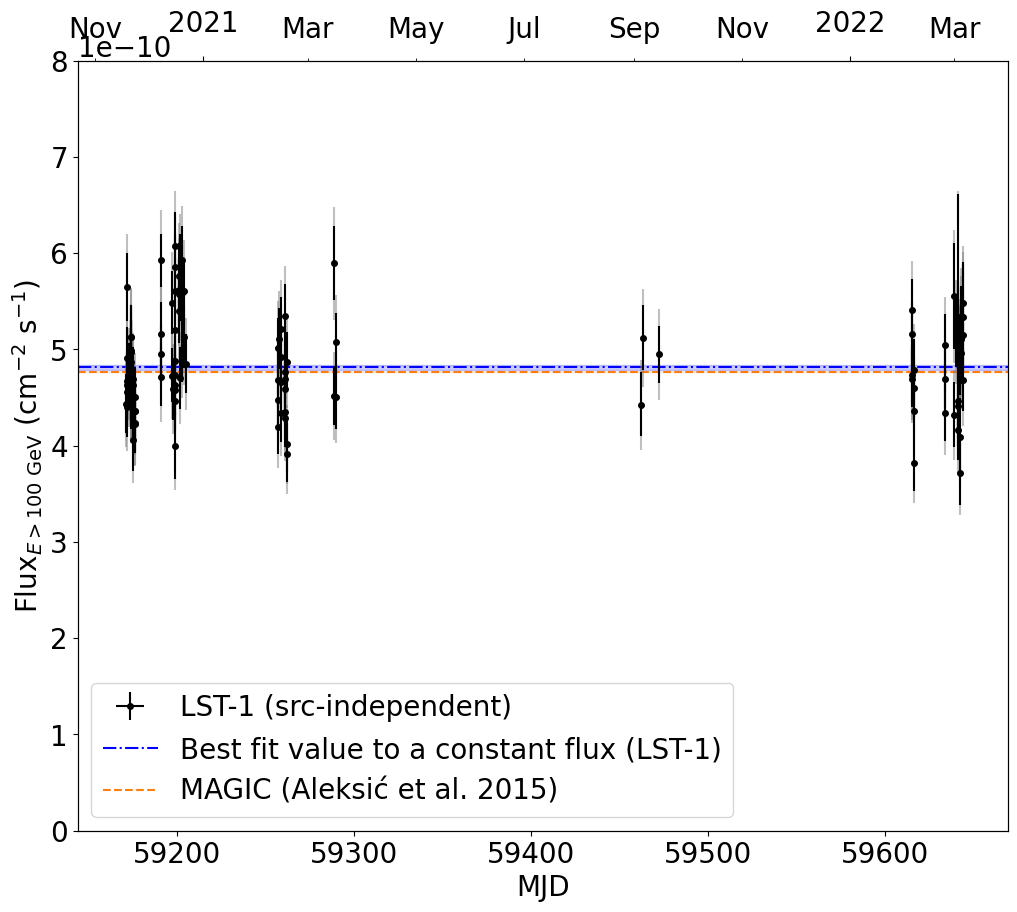

In [35]:
plt.figure(figsize=(12, 10))

TimeMapAxis.time_format = "mjd"

plt.axhline(
    mean_flux, c='b', ls='-.',
    label='Best fit value to a constant flux (LST-1)',
)

plt.axhspan(
    mean_flux - mean_flux_err, 
    mean_flux + mean_flux_err, 
    alpha=0.2, color='b'
)

# Plot Crab MAGIC reference
plt.axhline(
        flux_crab.to_value("cm-2 s-1"), 
        c='tab:orange',
        ls='--', 
        label='MAGIC (Aleksić et al. 2015)',
)
plt.axhspan(
        (flux_crab - flux_crab_error).to_value("cm-2 s-1"), 
        (flux_crab + flux_crab_error).to_value("cm-2 s-1"), 
        alpha=0.2, color='tab:orange'
)

ax = plt.gca()
set_twin_time_axis(ax)

plot_total_error_bars(0.075, lightcurve)

lc_night_runwise.plot(
    ax = ax,
    sed_type="flux", 
    marker = "o",
    color='black',
    label='LST-1 (src-independent)',
)

ax.set_xlabel("MJD", fontsize=20)
ax.set_ylabel(r"Flux$_{E > 100 \rm{~GeV}}$ (cm$^{-2}$ s$^{-1}$)", fontsize=20)
ax.yaxis.get_offset_text().set_fontsize(20)
plt.yscale('linear')
plt.ylim(0, 8e-10)

# Reorder labels in the legend
handles, labels = ax.get_legend_handles_labels()
order = [2, 0, 1]
plt.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order], 
    loc="lower left",
    fontsize=20
)

plt.savefig("LC_crab_src-indep_100GeV_30TeV_v0.9.9_runwise.pdf", bbox_inches='tight')